# Installs

In [1]:
#@title Install POLICE-robustness

!git clone https://github.com/Josuelmet/POLICE-robustness.git
!mv POLICE-robustness/police.py .

Cloning into 'POLICE-robustness'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), 4.50 KiB | 1.13 MiB/s, done.


In [2]:
#@title Install SplineCAM + dependencies

!pip install --upgrade gdown
!git clone https://github.com/AhmedImtiazPrio/splinecam.git

!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25

!echo "deb http://cz.archive.ubuntu.com/ubuntu bionic main universe" >> /etc/apt/sources.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

#python3-cairo from Ubuntu's reposity is linked with a different python version; we need to improvise
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard
!pip install networkx
!pip install python-igraph>=0.10
!pip install tqdm
!pip install livelossplot

!pip uninstall torch torchvision -y
!pip install --pre torch==1.12+cu116 torchvision -f https://download.pytorch.org/whl/torch_stable.html

!mkdir animation
!pip install imageio-ffmpeg

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Cloning into 'splinecam'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 164 (delta 25), reused 12 (delta 11), pack-reused 126
Receiving objects: 100% (164/164), 57.21 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (79/79), done.
Executing: /tmp/apt-key-gpghome.0DwNUMHfmE/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
H

# Setup + Hyperparameters

In [113]:
#@title Helper Functions and Imports


import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons, make_circles, make_blobs

import torch
import torch.nn as nn
from torch import Tensor

import copy
import os
import time
import tqdm

import sys
sys.path.append('./splinecam')
sys.path.append('./POLICE-robustness')

from police import *


def make_dataloader(generator,n,
                 noise=0.05,seed=0,
                 batch_size=128,
                 imbalanced=False,
                 minority_size=25):

    if generator == make_moons:
        X,y = generator(n_samples=n,
                        shuffle=False,
                        noise=noise,
                        random_state=seed)
    else:
        X,y = generator(n_samples=n,
                        shuffle=False,
                        cluster_std=0.8,
                        centers=np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]]) * 2,
                        random_state=seed)


    inputs = torch.hstack([
        torch.Tensor(X),torch.Tensor(y[...,None])
    ])

    if generator != make_moons:
        inputs[:, 2] = inputs[:, 2] % 2

    if imbalanced:
        minority_idx = np.arange(len(inputs))[inputs[:, 2] == 1]
        minority_idx = np.sort(np.random.choice(minority_idx, minority_size, replace=False))
        inputs = torch.vstack([inputs[inputs[:,2] == 0],
                               inputs[minority_idx]])

    dataloader = torch.utils.data.DataLoader(inputs,
                                             batch_size=batch_size,
                                             pin_memory=True,
                                             shuffle=True)
    return dataloader



import splinecam as splinecam



@torch.no_grad()
def get_hyp_endpoints(poly,hyps,verify=True):

    q = splinecam.graph.get_intersection_pattern(poly,hyps)
    hyp_v1_v2_idx = splinecam.graph.edge_hyp_intersections(q.T,poly,hyps)
    poly_lines = splinecam.graph.make_line_2D(poly[hyp_v1_v2_idx[:,1]],poly[hyp_v1_v2_idx[:,2]])

    poly_int_hyps = hyps[hyp_v1_v2_idx[:,0]]
    v,flag = splinecam.graph.find_intersection_2D(poly_lines,
                                  poly_int_hyps,
                                  verify=verify)

    v = v.type(poly_lines.type())

    if verify:

        assert flag

        flag = splinecam.graph.verify_collinear(v,
                                poly[hyp_v1_v2_idx[:,1]],
                                poly[hyp_v1_v2_idx[:,2]]
                                )

        assert flag

    hyp_endpoints = v.reshape(-1,2,v.shape[-1])
    return hyp_endpoints


@torch.no_grad()
def to_next_layer_partition_batched(cycles, Abw, current_layer, NN,
                                    dtype=torch.float64, device='cuda',
                                    batch_size=-1, fwd_batch_size=-1):

    if batch_size == -1: ## revert to non-batched
        res_regions, new_cyc_idx = splinecam.graph.to_next_layer_partition(
            cycles, Abw, current_layer, NN, dtype, device
        )
        return res_regions, new_cyc_idx

    vec_cyc,cyc_idx,ends = splinecam.graph.cycles_list2vec(cycles)

#     cycles_next = NN.layers[:current_layer].forward(vec_cyc[:128].to(device))
#     q = NN.layers[current_layer].get_intersection_pattern(cycles_next)

#     print(q.shape)

    fused_op = lambda x: NN.layers[current_layer].get_intersection_pattern(
        NN.layers[:current_layer].forward(x))


    q = splinecam.graph._batched_gpu_op(fused_op,
                        vec_cyc,
                        workers = 2,
                        out_size=(
                            vec_cyc.shape[0],
                            torch.prod(NN.layers[current_layer].output_shape),
                        ),
                        batch_size = fwd_batch_size, out_device='cpu')


    n_hyps  = torch.prod(NN.layers[current_layer].output_shape)

    ## edge intersections. remove between cycles
    mask = q.T[...,:-1] != q.T[...,1:]
    mask = mask.cpu()
    mask[:,(ends-1)[:-1]] = False

    if mask.sum() == 0:
        print('no intersections')
        return

#     del  q
#     del cycles_next

    ## get indices for hyps-vertex-cycle triads
    hyp_vert_idx = torch.vstack(torch.where(mask)).T
    hyp_vert_cyc_idx = torch.hstack([hyp_vert_idx,cyc_idx[hyp_vert_idx[:,1:]]])

    ## assert all cycles occur twice in order
    assert torch.all(hyp_vert_cyc_idx[::2,2] == hyp_vert_cyc_idx[1::2,2])

    ## query hyps, only get rows which intersect, create idx map
    inter_hyps_idx = torch.unique(hyp_vert_cyc_idx[:,0])
    print(inter_hyps_idx)
    hyps = NN.layers[current_layer].get_weights(row_idx=inter_hyps_idx).cpu()
    hyp_idx_map = torch.ones(n_hyps,dtype=torch.int64)*(hyps.shape[0]+100) ## initialize with idx out of range
    hyp_idx_map[inter_hyps_idx] = torch.arange(hyps.shape[0], dtype=torch.int64)

    ## bring hyps to corresponding cycle inputs

    hyps_input = splinecam.graph._batched_gpu_op_2(
        method = splinecam.graph.hyp2input,
        data1 = hyps[hyp_idx_map[hyp_vert_cyc_idx[::2,0]]],
        data2 = Abw[hyp_vert_cyc_idx[::2,2]],
        batch_size = batch_size,
        out_size = (hyp_vert_cyc_idx[::2,0].shape[0],1,3),
        dtype = dtype
    )[:,0,:]

    uniq_cycle_idx = torch.unique(hyp_vert_cyc_idx[:,-1])

###     get intersection with all cycle edges
    endpoints = []
    for target_cycle_idx in tqdm.tqdm(uniq_cycle_idx, desc='Iterating regions'):

        vert_mask = cyc_idx==target_cycle_idx
        hyp_mask = hyp_vert_cyc_idx[::2,-1] == target_cycle_idx

        endpoints.append(get_hyp_endpoints(
            poly = vec_cyc[vert_mask].to(device),
            hyps = hyps_input[hyp_mask].to(device),

        ))

    return hyps_input.cpu(),torch.vstack(endpoints).cpu()

def get_partitions_with_db(
    domain,
    T,
    NN,
    fwd_batch_size = 1024,
    batch_size = 128,
    n_workers = 2,
    Abw_batch_size = 16,
):

    poly = (T[...,:-1].T @ (domain.T - T[...,-1:])).T
    poly = poly.type(torch.float64)

    start_time = time.time()

    ### Get partitions

    Abw = NN.layers[0].get_weights()[None,...].cpu()

    out_cyc = [poly]


    for current_layer in range(1,len(NN.layers)-1):
        print(f'Current layer {current_layer}')

        out_cyc,out_idx = splinecam.graph.to_next_layer_partition_batched(
            cycles = out_cyc,
            Abw = Abw,
            NN = NN,
            current_layer = current_layer,
            dtype = torch.float64,
            batch_size=batch_size,
            fwd_batch_size=fwd_batch_size,
        )

        with torch.no_grad():

            means = splinecam.utils.get_region_means(out_cyc, dims=out_cyc[0].shape[-1], device = 'cpu', dtype=torch.float64)

            fused_op = lambda x:NN.layers[
                current_layer
            ].get_activation_pattern(
                NN.layers[:current_layer].forward(x)
            ).cpu().type(torch.float32)


            q = splinecam.graph._batched_gpu_op(method=fused_op,
                            data=means,
                            batch_size=fwd_batch_size,
                            out_size=(
                                means.shape[0],torch.prod(NN.layers[current_layer].output_shape)
                            ),
                            dtype= torch.float32,
                            workers=n_workers,
                )


            del means

            Wb =  NN.layers[current_layer].get_weights(dtype=torch.float32).cuda()
            Abw = Abw.type(torch.float32)

            dloader = torch.utils.data.DataLoader(Abw,
                                          pin_memory=True,
                                          batch_size=Abw_batch_size,
                                          num_workers=n_workers,
                                          shuffle=False,
                                          sampler=out_idx,
                                          drop_last=False)

            out_Abw = torch.zeros(len(out_idx),Wb.shape[0],Abw.shape[-1], device='cpu', dtype=torch.float32)

            start = 0
            for in_batch in tqdm.tqdm(dloader,desc='Get Abw',total=len(dloader)):

                end = start+in_batch.shape[0]

                out_batch = splinecam.utils.get_Abw(
                        q = q[start:end].cuda(),
                        Wb = Wb.to_dense(),
                        incoming_Abw = in_batch.cuda()
                            )

                out_Abw[start:end] = out_batch.cpu()
                start = end

            Abw = out_Abw.type(torch.float64)

        del Wb, out_Abw

    elapsed_time = time.time()-start_time
    print(f'Time elapsed {elapsed_time/60:.3f} minutes')

    try:
        hyp2input,endpoints = to_next_layer_partition_batched(out_cyc, Abw, -1, NN,
                                        dtype=torch.float64, device='cuda',
                                        batch_size=batch_size,
                                        fwd_batch_size=fwd_batch_size)
    except:
        endpoints = [None]

    return out_cyc,endpoints

In [114]:
#@title Experiment Hyperparameters
constrained = True #@param {type:"boolean"}
constrain_all_layers = False #@param {type:"boolean"}
fine_tune_constraints = True #@param {type:"boolean"}
constraint_eps = 0.3 #@param {type:"number"}
dataset = "moons" #@param ["moons", "blobs"]
imbalanced = True #@param {type:"boolean"}

(-2.046923875808716, 2.6145594120025635)

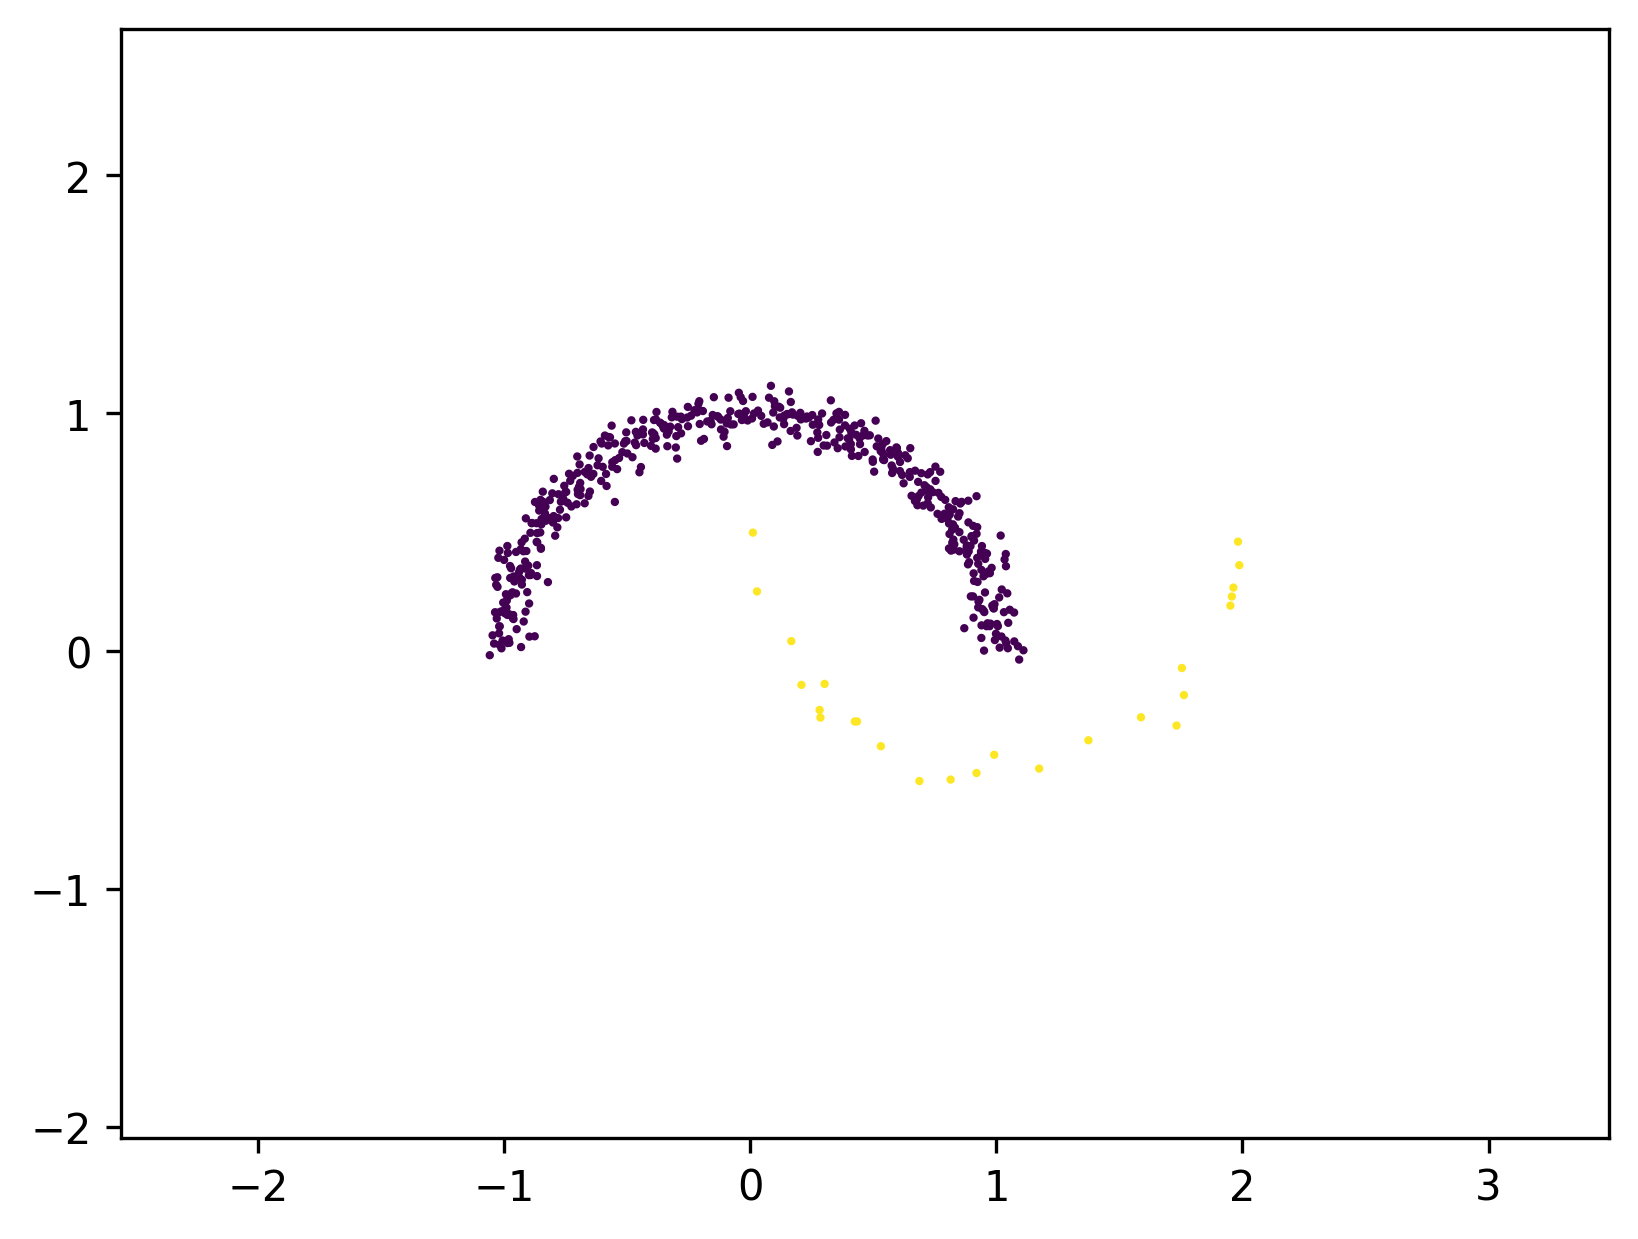

In [115]:
#@title Prepare Data and Specify Input Domain

# prepare data

dataloader = make_dataloader(make_moons if dataset == "moons" else make_blobs,
                             1000, imbalanced=imbalanced)

# get upper and lower bounds
xlow,ylow = dataloader.__dict__['dataset'][:,:-1].min(0)[0].numpy()
xhigh,yhigh = dataloader.__dict__['dataset'][:,:-1].max(0)[0].numpy()

# ROI square domain at the input space
pad = 1.5
domain = torch.tensor([
    [xlow,ylow],
    [xlow,yhigh],
    [xhigh,yhigh],
    [xhigh,ylow],
    [xlow,ylow]
])

domain += np.sign(domain)*1.5

# Get projection matrix for 2D<->input
T = torch.eye(3)[:-1]

## plot data and set domain boundaries
plt.scatter(dataloader.__dict__['dataset'][:,:-1].numpy()[:,0],
            dataloader.__dict__['dataset'][:,:-1].numpy()[:,1],
            c = dataloader.__dict__['dataset'][:,-1].numpy(),s=1,
           )
plt.xlim([domain[0][0],domain[2][0]])
plt.ylim([domain[0][1],domain[2][1]])

# Training

In [116]:
#@title Specify Network
torch.backends.cudnn.deterministic=True

if constrained:
    constraints = dataloader.dataset[dataloader.dataset[:,2] == 1, :2]

    assert len(constraints.shape) == 2

    constraints = constraints.reshape(constraints.shape[0], 1, constraints.shape[1]).repeat(1, 8, 1)

    s = np.sqrt(2) / 2
    constraints +=  torch.Tensor([[0, -1],
                                  [s, -s],
                                  [1,  0],
                                  [s,  s],
                                  [0,  1],
                                  [-s, s],
                                  [-1, 0],
                                  [-s,-s]]).unsqueeze(0) * constraint_eps


width = 10
depth = 5

def layers(depth):
    ls = []
    for _ in range(depth):
        ls.extend([nn.Linear(width, width), nn.ReLU()])
    return ls


model = nn.Sequential(
    nn.Linear(2,width),
    nn.ReLU(),
    *layers(depth-2),
    nn.Linear(width,1)
)

# temp code
if constrained and not fine_tune_constraints:
    if not constrain_all_layers:
        model._modules['0'].do_not_constrain = True
        model._modules['2'].do_not_constrain = True
        model._modules['4'].do_not_constrain = True
        model._modules['6'].do_not_constrain=True

    model = ConstrainedSequential.cast(model, constrain_last=True)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
dtype = torch.float64

model = model.to(device).to(dtype)
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): ReLU()
  (8): Linear(in_features=10, out_features=1, bias=True)
)

100%|██████████| 400/400 [00:06<00:00, 59.10it/s]


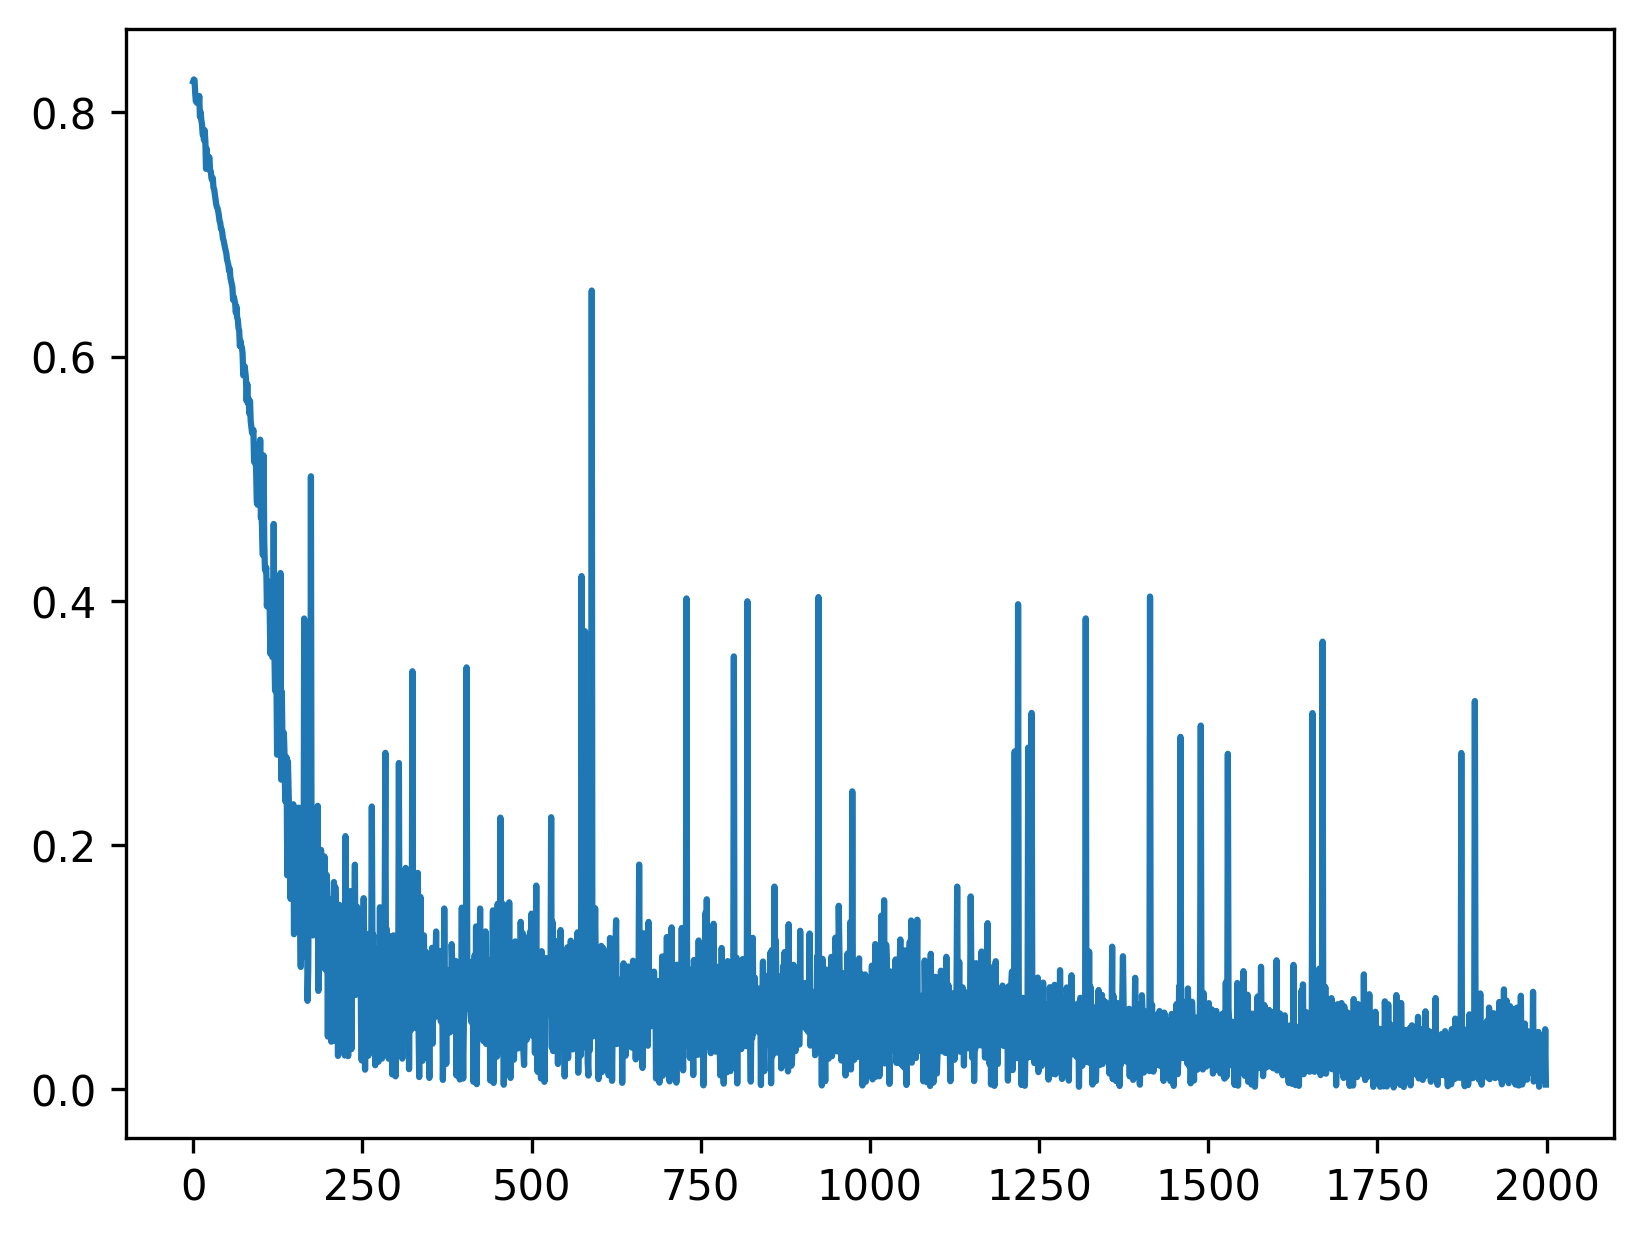

In [117]:
#@title Train model

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

epochs = 200 * 2
#assert is_constrained(model)
if constrained:
    constraints = constraints.to(device).to(dtype)

history = []

for epoch in tqdm.tqdm(range(1, epochs + 1)):

    ## train step

    model.train()
    total_loss = 0
    for batch_idx, data in enumerate(dataloader, 1):

        # prep data
        data,target = data[:,:-1],data[:,-1:]
        data, target = data.to(device).to(dtype), target.to(device).to(dtype)

        optimizer.zero_grad() # zero accumulated gradients
        if is_constrained(model):
            output = model(data, constraints)
        else:
            output = model(data)

        # calculate loss and perform backprop
        loss = criterion(output, target)
        history.append(loss.item())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

if is_constrained(model):
    model(torch.Tensor([]).to(device).to(dtype), constraints)

plt.plot(history)
plt.show()

In [118]:
#@title Fine-tune the model on the constraints (if "constrained" is True)

if constrained and fine_tune_constraints:

    epochs = 5
    if not is_constrained(model):
        if not constrain_all_layers:
            model._modules['0'].do_not_constrain = True
            model._modules['2'].do_not_constrain = True
            model._modules['4'].do_not_constrain = True
            model._modules['6'].do_not_constrain=True

        model = ConstrainedSequential.cast(model, constrain_last=True)
    assert is_constrained(model)

    history = []

    for epoch in tqdm.tqdm(range(1, epochs + 1)):

        ## train step

        model.train()
        total_loss = 0
        for batch_idx, data in enumerate(dataloader, 1):

            # prep data
            data,target = data[:,:-1],data[:,-1:]
            data, target = data.to(device).to(dtype), target.to(device).to(dtype)

            optimizer.zero_grad() # zero accumulated gradients
            output = model(data, constraints)

            # calculate loss and perform backprop
            loss = criterion(output, target)
            history.append(loss.item())
            loss.backward()
            optimizer.step()

100%|██████████| 5/5 [00:00<00:00, 35.03it/s]


# Evaluation

Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Current layer 1


Iterating regions: 100%|██████████| 1/1 [00:00<00:00, 11.90it/s]

Finding regions from first layer graph



Get Abw: 100%|██████████| 3/3 [00:00<00:00, 16.59it/s]

Current layer 2



iterating hyps: 100%|██████████| 2/2 [00:00<00:00, 279.56it/s]

iterating hyps: 100%|██████████| 7/7 [00:00<00:00, 445.58it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 464.30it/s]

iterating hyps: 100%|██████████| 5/5 [00:00<00:00, 427.28it/s]

iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 706.75it/s]

Get Abw: 100%|██████████| 10/10 [00:00<00:00, 47.18it/s]

Current layer 3



iterating hyps: 100%|██████████| 6/6 [00:00<00:00, 954.01it/s]

iterating hyps: 100%|██████████| 3/3 [00:00<00:00, 563.90it/s]

Get Abw: 100%|██████████| 20/20 [00:00<00:00, 48.78it/s]

Current layer 4



Get Abw: 100%|██████████| 28/28 [00:00<00:00, 56.83it/s]

Time elapsed 0.106 minutes


tensor([0])


100%|██████████| 442/442 [00:00<00:00, 928.12it/s]


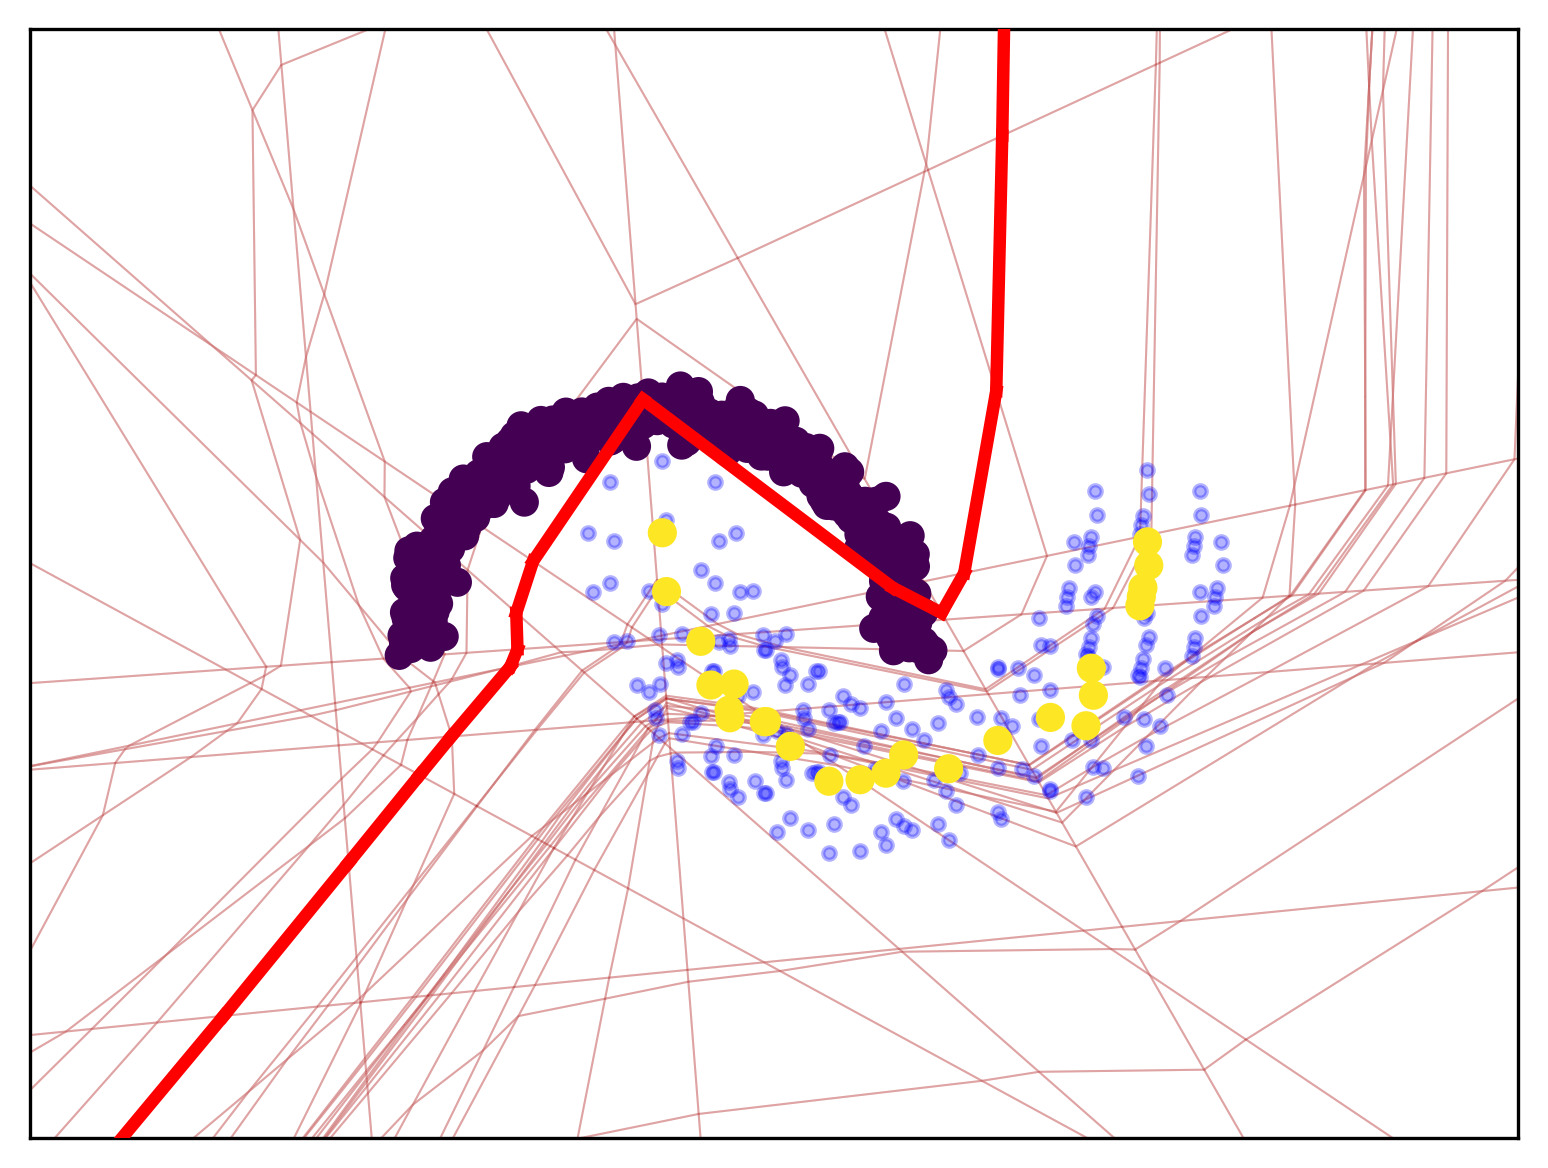

In [119]:
#@title Uncast model + run SplineCam

## visualize partition

if is_constrained(model) and not fine_tune_constraints:
    model(torch.Tensor([]).to(device).to(dtype), constraints)
if is_constrained(model):
    model = ConstrainedSequential.uncast(model)
model.to(device)
model.eval()

model.type(dtype)

print('Wrapping model with SplineCam...')

NN = splinecam.wrappers.model_wrapper(
    model, #nn.Sequential(model._modules).eval(), #model,
    input_shape=(2,),
    T = T,
    dtype = dtype,
    device = 'cuda'
)

## check .forward() and matmul operation equivalence
# print('Verifying wrapped model...')
flag =  NN.verify()
# print('Model.forward and matmul equivalence check', flag)
assert flag

## specify level set for output neuron, for db visualization
thresh = 0.5
NN.layers[-1].Ab[0,-1] = NN.layers[-1].Ab[0,-1] + thresh


## get partitions
out_cyc,endpoints = splinecam.compute.get_partitions_with_db(domain,T,NN)


plt.rcParams['figure.dpi'] = 300
fig,ax = plt.subplots()

for each in endpoints:
    if each is not None:
        ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=3)

minval,_ = torch.vstack(out_cyc).min(0)
maxval,_ = torch.vstack(out_cyc).max(0)

splinecam.plot.plot_partition(out_cyc, xlims=[minval[0],maxval[0]],alpha=0.2,
                          edgecolor='#a70000',color_range=[.3,.8],ax=ax,colors=['none'],
                          ylims=[minval[1],maxval[1]], linewidth=.5)


if constrained: # and not fine_tune_constraints:
    for c in constraints.cpu().numpy():
        ax.scatter(c[:,0], c[:,1], c='blue', marker='.', alpha=0.3)


ax.scatter(dataloader.__dict__['dataset'][:,:-1].numpy()[:,0],
            dataloader.__dict__['dataset'][:,:-1].numpy()[:,1],
            c = dataloader.__dict__['dataset'][:,-1].numpy()
            )

'''
plt.savefig(f'./animation/{epoch}.png',bbox_inches='tight',pad_inches=0)

model.cuda()
model.train()
model.type(dtype)

# print loss stats
print("Epoch: {}, Loss: {}".format(epoch, total_loss / len(dataloader)))
''';

del NN, out_cyc, endpoints


In [120]:
@torch.no_grad()
def check_layerwise_signs(model,constraints):
    v = constraints
    layerwise_flags = []
    layerwise_unmatched_act = []
    '''
    skip_all_next = False
    '''
    for m in model._modules.values():
        if is_constrained(m):
            v = m(v, R=len(constraints), V=1)
        else:
            v = m(v)

        # If this layer was never constrained:
        if 'last_extra_bias' not in vars(m):
            continue

        v_sign = v > 0
        match = v_sign  != v_sign[0,...]
#         print('Abs sum of sign unmatched activ.', torch.sum(torch.abs(v[match])))
        layerwise_unmatched_act.append(torch.sum(torch.abs(v[match])))
        layerwise_flags.append(torch.all(v_sign  == v_sign[0,...]))

    return layerwise_flags, layerwise_unmatched_act

In [121]:
for each_constraint in constraints:
    flags, unmatched_act = check_layerwise_signs(model, each_constraint.to(device).to(dtype))

    # Index up to :-1 because the last layer's signs do not need to agree.
    print('All signs agree', all(flags[:-1]))
    print('Abs sum of activations that disagree',sum(unmatched_act[:-1]))


flags

All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activations that disagree 0
All signs agree True
Abs sum of activati

[tensor(True, device='cuda:0')]